Shitty project nr 4. Catastrophic forgetting...

In [1]:
""" Needed Libraries """
from copy import deepcopy
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms, datasets
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from typing import Optional

import multiprocessing

""" Constants """

BATCH_SIZE = 1  # should be 1
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 1e-3

## Data Recovery and Processing ##

In [2]:
# find out which device is available
def device_type():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"


DEVICE = torch.device(device_type())
print(DEVICE)

cpu


In [3]:
"""
The magical permutation object that will permutate all of
our images deterministically, effectively making learning each permutation a unique task.
"""


class RandomPermutation(object):
    def __init__(self, num_features: int, generator: torch.Generator):
        self.num_features = num_features
        self.reindex = torch.randperm(num_features, generator=generator)

    def __call__(self, img):
        assert self.num_features == img.numel()

        orig_shape = img.shape
        img = img.view(-1)[self.reindex].view(orig_shape)

        return img

In [4]:
def data_generation(
    seed: int,
    num_workers: int = 2,
    batch_size: int = BATCH_SIZE,
    test_size: int = TEST_BATCH_SIZE,
):
    task_generator = torch.Generator()
    task_generator.manual_seed(seed)

    transform = T.Compose(
        [
            T.ToTensor(),
            T.Normalize((0.5,), (0.5,)),
            RandomPermutation(28 * 28, task_generator),
        ]
    )

    train_dataset = torchvision.datasets.MNIST(
        root="./data/", train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root="./data/", train=False, download=True, transform=transform
    )

    train_dataset, valid_dataset = random_split(train_dataset, lengths=[50000, 10000])

    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_dataloader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=test_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=test_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return test_dataloader, train_dataloader, valid_dataloader

In [5]:
testA_dataloader, trainA_dataloader, validA_dataloader = data_generation(
    1, num_workers=0
)
testB_dataloader, trainB_dataloader, validB_dataloader = data_generation(
    2321, num_workers=0
)
testC_dataloader, trainC_dataloader, validC_dataloader = data_generation(
    103032, num_workers=0
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 28, 28])

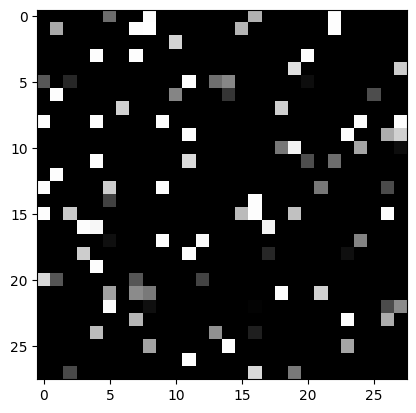

In [6]:
# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(trainC_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)


def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")


show(grid)

images[0].shape

## Modelling ##

### The deep NN ###

In [7]:
class MLP_Net_A(nn.Module):
    def __init__(self):
        # define the different modules of the network
        super().__init__()

        self.hl1 = nn.Linear(28 * 28, 400)
        self.hl2 = nn.Linear(400, 400)
        self.ol = nn.Linear(400, 10)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Image to vector (flatten)
        x = x.view(x.shape[0], -1)

        x = self.hl1(x)
        x = self.relu(x)
        x = self.hl2(x)
        x = self.relu(x)
        x = self.ol(x)

        return x


class MLP_Net_B(nn.Module):
    def __init__(self):
        # define the different modules of the network
        super().__init__()

        self.hl1 = nn.Linear(28 * 28, 2000)
        self.hl2 = nn.Linear(2000, 2000)
        self.ol = nn.Linear(2000, 10)
        self.relu = nn.ReLU()
        self.dropout_input = nn.Dropout(p=0.2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Image to vector (flatten)
        x = x.view(x.shape[0], -1)

        x = self.hl1(x)
        x = self.relu(x)
        x = self.dropout_input(x)

        x = self.hl2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.ol(x)

        return x

### Basic Training functions etc ###

In [8]:
def GS_lambda(
    checkpoint,
    train_dataloader,
    valid_dataloaders,
    lams,
    current_lams,
    fishers,
    old_params,
):
    val_accs = []
    for lam in lams:
        print(lam)
        model = MLP_Net_A()
        model = model_ewc.to(DEVICE)
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

        # Load model state
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        # Train
        (
            epochs_list,
            losses_EWC_training,
            losses_EWC_validation,
            accuracy_EWC_validation,
        ) = ewc_training(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            epochs=1,
            device=DEVICE,
            ewc_lambda=current_lams + [lam],
            fishers=fishers,
            old_param=old_params,
        )

        GS_set = torch.utils.data.ConcatDataset(
            [dl.dataset for dl in valid_dataloaders]
        )

        GS_loader = DataLoader(GS_set, shuffle=True, batch_size=len(GS_set))

        _, val_acc = predict(model, GS_loader)

        val_accs.append(val_acc)

    return lams[val_accs.index(max(val_accs))]

In [9]:
def predict(
    model: nn.Module,
    test_dataloader: DataLoader,
    device: torch.device = DEVICE,
    verbose=True,
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction="sum")
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy

In [10]:
def estimate_fisher_diagonal(
    model: nn.Module, dataloader: DataLoader, device: str = DEVICE
):
    precision_matrices = {}
    for name, param in deepcopy(model).named_parameters():
        precision_matrices[name] = torch.zeros_like(param.data)

    model.eval()

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()

        output = model(inputs).view(1, -1)
        label = output.max(1)[1].view(-1)
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)
        # loss = F.cross_entropy(output, label)

        loss.backward()

        for name, param in model.named_parameters():
            if name in precision_matrices:
                precision_matrices[name].data += param.grad.data.clone() ** 2 / len(
                    dataloader
                )

    return {name: param for name, param in precision_matrices.items()}

### EWC training ###

In [11]:
def ewc_training(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    fishers: list,
    old_param: list,
    ewc_lambda: list,
    s_epoch: int = 0,
    valid_dataloaders=None,
):
    """
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    """

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accuracys = []
    epochslist = range(s_epoch, epochs + s_epoch)

    for epoch in epochslist:
        running_loss = 0.0
        model = model.to(device)
        model.train()

        for _, (data, target) in enumerate(train_dataloader):
            # move data and target to device
            data, target = data.to(device), target.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # do the forward pass
            output = model(data)

            # compute the loss
            loss_ce = F.cross_entropy(output, target)

            # Calculate EWC regularization term
            loss_ewc = 0
            for task in range(len(fishers)):
                for name, param in model.named_parameters():
                    loss_ewc += (
                        ewc_lambda[task]
                        / 2
                        * (
                            fishers[task][name] * (param - old_param[task][name]) ** 2
                        ).sum()
                    )

            loss = loss_ce + loss_ewc

            # compute the gradient
            loss.backward()

            # perform the gradient step
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        if valid_dataloaders is not None:
            temp_acc = []
            temp_loss = []
            for dataloader in valid_dataloaders:
                valid_loss, valid_acc = predict(
                    model, dataloader, device, verbose=False
                )
                temp_loss.append(valid_loss)
                temp_acc.append(float(valid_acc))

            valid_losses.append(temp_loss)
            valid_accuracys.append(temp_acc)

        if valid_dataloaders is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            text = f"Epoch {epoch}: Train Loss={train_loss:.4f}"
            for idx, acc in enumerate(temp_acc):
                text += (
                    f" Validation Loss={temp_loss[idx]:.4f}, Validation Acc={acc:.0f}%"
                )

            print(text)
    return (
        epochslist,
        train_losses,
        [list(i) for i in zip(*valid_losses)],
        [list(i) for i in zip(*valid_accuracys)],
    )

### L2 training ###

In [12]:
def l2_training(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    old_param: list,
    s_epoch: int = 0,
    valid_dataloaders=None,
    l2_lambda: float = 0,
):
    """
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    """

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accuracys = []
    epochslist = range(s_epoch, epochs + s_epoch)

    for epoch in epochslist:
        running_loss = 0.0
        model = model.to(device)
        model.train()

        for _, (data, target) in enumerate(train_dataloader):
            # move data and target to device
            data, target = data.to(device), target.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # do the forward pass
            output = model(data)

            # compute the loss
            loss_ce = F.cross_entropy(output, target)

            # Calculate l2 regularization term
            loss_l2 = 0
            for task in range(len(old_param)):
                for name, param in model.named_parameters():
                    loss_l2 += ((param - old_param[task][name]) ** 2).sum()

            loss = loss_ce + l2_lambda / 2 * loss_l2

            # compute the gradient
            loss.backward()

            # perform the gradient step
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        if valid_dataloaders is not None:
            temp_acc = []
            temp_loss = []
            for dataloader in valid_dataloaders:
                valid_loss, valid_acc = predict(
                    model, dataloader, device, verbose=False
                )
                temp_loss.append(valid_loss)
                temp_acc.append(float(valid_acc))

            valid_losses.append(temp_loss)
            valid_accuracys.append(temp_acc)

        if valid_dataloaders is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            text = f"Epoch {epoch}: Train Loss={train_loss:.4f}"
            for idx, acc in enumerate(temp_acc):
                text += (
                    f" Validation Loss={temp_loss[idx]:.4f}, Validation Acc={acc:.0f}%"
                )

            print(text)
    return (
        epochslist,
        train_losses,
        [list(i) for i in zip(*valid_losses)],
        [list(i) for i in zip(*valid_accuracys)],
    )

### SGD training ###

In [13]:
def sgd_training(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    s_epoch: int = 0,
    valid_dataloaders=None,
):
    """
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    """

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accuracys = []
    epochslist = range(s_epoch, epochs + s_epoch)

    for epoch in epochslist:
        running_loss = 0.0
        model = model.to(device)
        model.train()

        for _, (data, target) in enumerate(train_dataloader):
            # move data and target to device
            data, target = data.to(device), target.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # do the forward pass
            output = model(data)

            # compute the loss
            loss = F.cross_entropy(output, target)

            # compute the gradient
            loss.backward()

            # perform the gradient step
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        if valid_dataloaders is not None:
            temp_acc = []
            temp_loss = []
            for dataloader in valid_dataloaders:
                valid_loss, valid_acc = predict(
                    model, dataloader, device, verbose=False
                )
                temp_loss.append(valid_loss)
                temp_acc.append(float(valid_acc))

            valid_losses.append(temp_loss)
            valid_accuracys.append(temp_acc)

        if valid_dataloaders is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            text = f"Epoch {epoch}: Train Loss={train_loss:.4f}"
            for idx, acc in enumerate(temp_acc):
                text += (
                    f" Validation Loss={temp_loss[idx]:.4f}, Validation Acc={acc:.0f}%"
                )

            print(text)
    return (
        epochslist,
        train_losses,
        [list(i) for i in zip(*valid_losses)],
        [list(i) for i in zip(*valid_accuracys)],
    )

### EWC ###

In [30]:
old_params = []
fishers = []
lambdas = []

In [43]:
model_ewc = MLP_Net_A()
model_ewc = model_ewc.to(DEVICE)

optimizer_ewc = optim.SGD(model_ewc.parameters(), lr=LEARNING_RATE)

# train for 20 epochs each training set based on TASK A  (validatiation set A) basic EWC
(
    epochs_list_1,
    losses_EWC_training_1,
    losses_EWC_validation_1,
    accuracy_EWC_validation_1,
) = sgd_training(
    model=model_ewc,
    train_dataloader=trainA_dataloader,
    valid_dataloaders=[validA_dataloader],
    optimizer=optimizer_ewc,
    epochs=20,
    device=DEVICE,
)

torch.save(
    {
        "model_state_dict": model_ewc.state_dict(),
        "optimizer_state_dict": optimizer_ewc.state_dict(),
        "training_losses": losses_EWC_training_1,
        "validation_losses": losses_EWC_validation_1,
        "validation_accuracy": accuracy_EWC_validation_1,
    },
    "model_ewc_A_check.tar",
)

Epoch 0: Train Loss=0.4440 Validation Loss=0.2550, Validation Acc=92%
Epoch 1: Train Loss=0.2030 Validation Loss=0.1777, Validation Acc=95%
Epoch 2: Train Loss=0.1425 Validation Loss=0.1482, Validation Acc=96%
Epoch 3: Train Loss=0.1104 Validation Loss=0.1290, Validation Acc=96%
Epoch 4: Train Loss=0.0887 Validation Loss=0.1097, Validation Acc=97%
Epoch 5: Train Loss=0.0746 Validation Loss=0.1042, Validation Acc=97%
Epoch 6: Train Loss=0.0625 Validation Loss=0.1119, Validation Acc=97%
Epoch 7: Train Loss=0.0544 Validation Loss=0.0995, Validation Acc=97%
Epoch 8: Train Loss=0.0462 Validation Loss=0.0944, Validation Acc=97%
Epoch 9: Train Loss=0.0390 Validation Loss=0.1254, Validation Acc=96%
Epoch 10: Train Loss=0.0347 Validation Loss=0.0870, Validation Acc=97%
Epoch 11: Train Loss=0.0298 Validation Loss=0.0936, Validation Acc=97%
Epoch 12: Train Loss=0.0265 Validation Loss=0.0886, Validation Acc=98%
Epoch 13: Train Loss=0.0234 Validation Loss=0.0845, Validation Acc=98%
Epoch 14: Train 

In [17]:
checkpoint = torch.load("model_ewc_A_check.tar", map_location=torch.device(DEVICE))

model_ewc = MLP_Net_A()
model_ewc = model_ewc.to(DEVICE)
optimizer_ewc = optim.SGD(model_ewc.parameters(), lr=LEARNING_RATE)

# Load model state
model_ewc.load_state_dict(checkpoint["model_state_dict"])
optimizer_ewc.load_state_dict(checkpoint["optimizer_state_dict"])

In [18]:
dataloaderA_fim = torch.utils.data.DataLoader(
    trainA_dataloader.dataset, batch_size=1, shuffle=True
)
fishers = [estimate_fisher_diagonal(deepcopy(model_ewc, dataloaderA_fim))]
old_params = [{n: p for n, p in deepcopy(model_ewc).named_parameters()}]

# lambdas = [GS_lambda(checkpoint, trainB_dataloader, [trainA_dataloader], [2e-1,2e0,2e1,2e2,2e3,2e4,2e5,2e6,2e7], lambdas, fishers, old_params)] #2e5 seems to be best
lambdas = [1e5]

In [60]:
# Task B
(
    epochs_list_2,
    losses_EWC_training_2,
    losses_EWC_validation_2,
    accuracy_EWC_validation_2,
) = ewc_training(
    model=model_ewc,
    train_dataloader=trainB_dataloader,
    valid_dataloaders=[validA_dataloader, validB_dataloader],
    optimizer=optimizer_ewc,
    epochs=20,
    device=DEVICE,
    ewc_lambda=lambdas,
    fishers=fishers,
    old_param=old_params,
    s_epoch=20,
)

torch.save(
    {
        "model_state_dict": model_ewc.state_dict(),
        "optimizer_state_dict": optimizer_ewc.state_dict(),
        "training_losses": losses_EWC_training_2,
        "validation_losses": losses_EWC_validation_2,
        "validation_accuracy": accuracy_EWC_validation_2,
    },
    "model_ewc_B_check.tar",
)

Epoch 20: Train Loss=0.8370 Validation Loss=0.0736, Validation Acc=98% Validation Loss=0.3440, Validation Acc=90%
Epoch 21: Train Loss=0.4252 Validation Loss=0.0552, Validation Acc=98% Validation Loss=0.2641, Validation Acc=92%
Epoch 22: Train Loss=0.3373 Validation Loss=0.0609, Validation Acc=98% Validation Loss=0.2471, Validation Acc=92%
Epoch 23: Train Loss=0.2889 Validation Loss=0.0424, Validation Acc=99% Validation Loss=0.1860, Validation Acc=95%
Epoch 24: Train Loss=0.2509 Validation Loss=0.0564, Validation Acc=98% Validation Loss=0.1840, Validation Acc=94%
Epoch 25: Train Loss=0.2252 Validation Loss=0.0457, Validation Acc=99% Validation Loss=0.1659, Validation Acc=95%
Epoch 26: Train Loss=0.2026 Validation Loss=0.0672, Validation Acc=98% Validation Loss=0.1988, Validation Acc=94%
Epoch 27: Train Loss=0.1897 Validation Loss=0.0586, Validation Acc=98% Validation Loss=0.1559, Validation Acc=95%
Epoch 28: Train Loss=0.1758 Validation Loss=0.0415, Validation Acc=99% Validation Loss=0

In [27]:
checkpoint = torch.load("model_ewc_B_check.tar", map_location=torch.device(DEVICE))

model_ewc = MLP_Net_A()
model_ewc = model_ewc.to(DEVICE)
optimizer_ewc = optim.SGD(model_ewc.parameters(), lr=LEARNING_RATE)

# Load model state
model_ewc.load_state_dict(checkpoint["model_state_dict"])
optimizer_ewc.load_state_dict(checkpoint["optimizer_state_dict"])

In [28]:
dataloaderB_fim = torch.utils.data.DataLoader(
    trainB_dataloader.dataset, batch_size=1, shuffle=True
)
fimA = estimate_fisher_diagonal(
    deepcopy(model_ewc), dataloaderA_fim
)  # needs to be updated
fimB = estimate_fisher_diagonal(deepcopy(model_ewc), dataloaderB_fim)
fishers = [
    {n: (fimA[n] + fimB[n]) / 2 for n, _ in deepcopy(model_ewc).named_parameters()}
]
old_params = [{n: p for n, p in deepcopy(model_ewc).named_parameters()}]


# lambdas = [GS_lambda(checkpoint, trainC_dataloader, [trainA_dataloader, trainB_dataloader], [2e0,2e1,2e2,2e3,8e4,1e5,2e5,4e5,2e6], [], fishers, old_params)]
lambdas = [2e3]

In [29]:
# Task C
(
    epochs_list_3,
    losses_EWC_training_3,
    losses_EWC_validation_3,
    accuracy_EWC_validation_3,
) = ewc_training(
    model=model_ewc,
    train_dataloader=trainC_dataloader,
    valid_dataloaders=[validA_dataloader, validB_dataloader, validC_dataloader],
    optimizer=optimizer_ewc,
    epochs=20,
    device=DEVICE,
    ewc_lambda=lambdas,
    fishers=fishers,
    old_param=old_params,
    s_epoch=40,
)

torch.save(
    {
        "model_state_dict": model_ewc.state_dict(),
        "optimizer_state_dict": optimizer_ewc.state_dict(),
        "training_losses": losses_EWC_training_3,
        "validation_losses": losses_EWC_validation_3,
        "validation_accuracy": accuracy_EWC_validation_3,
    },
    "model_ewc_C_check.tar",
)

Epoch 40: Train Loss=0.7657 Validation Loss=0.1687, Validation Acc=95% Validation Loss=0.1476, Validation Acc=96% Validation Loss=0.4032, Validation Acc=87%
Epoch 41: Train Loss=0.5173 Validation Loss=0.1564, Validation Acc=95% Validation Loss=0.1368, Validation Acc=96% Validation Loss=0.2903, Validation Acc=91%
Epoch 42: Train Loss=0.4351 Validation Loss=0.1692, Validation Acc=94% Validation Loss=0.1510, Validation Acc=96% Validation Loss=0.3071, Validation Acc=91%
Epoch 43: Train Loss=0.3941 Validation Loss=0.2279, Validation Acc=92% Validation Loss=0.1570, Validation Acc=95% Validation Loss=0.2649, Validation Acc=92%
Epoch 44: Train Loss=0.3682 Validation Loss=0.2153, Validation Acc=93% Validation Loss=0.1326, Validation Acc=96% Validation Loss=0.2340, Validation Acc=93%
Epoch 45: Train Loss=0.3518 Validation Loss=0.1729, Validation Acc=94% Validation Loss=0.1329, Validation Acc=96% Validation Loss=0.2076, Validation Acc=94%
Epoch 46: Train Loss=0.3401 Validation Loss=0.2590, Valida

### L2 ###

In [ ]:
old_params = []

In [ ]:
model_l2 = MLP_Net_A()
model_l2 = model_l2.to(DEVICE)

optimizer_l2 = optim.SGD(model_l2.parameters(), lr=LEARNING_RATE)

# train for 20 epochs each training set based on TASK A  (validatiation set A) basic L2
(
    epochs_list_1,
    losses_L2_training_1,
    losses_L2_validation_1,
    accuracy_L2_validation_1,
) = sgd_training(
    model=model_l2,
    train_dataloader=trainA_dataloader,
    valid_dataloaders=[validA_dataloader],
    optimizer=optimizer_l2,
    epochs=20,
    device=DEVICE,
)

torch.save(
    {
        "model_state_dict": model_l2.state_dict(),
        "optimizer_state_dict": optimizer_l2.state_dict(),
        "training_losses": losses_L2_training_1,
        "validation_losses": losses_L2_validation_1,
        "validation_accuracy": accuracy_L2_validation_1,
    },
    "model_l2_A_check.tar",
)

In [ ]:
checkpoint = torch.load("model_l2_A_check.tar")

model_l2 = MLP_Net_A()
model_l2 = model_l2.to(DEVICE)
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=LEARNING_RATE)

# Load model state
model_l2.load_state_dict(checkpoint["model_state_dict"])
optimizer_l2.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
old_params.append({n: p for n, p in deepcopy(model_ewc).named_parameters()})

In [ ]:
# Task B
(
    epochs_list_2,
    losses_L2_training_2,
    losses_L2_validation_2,
    accuracy_L2_validation_2,
) = l2_training(
    model=model_l2,
    train_dataloader=trainB_dataloader,
    valid_dataloaders=[validA_dataloader, validB_dataloader],
    optimizer=optimizer_l2,
    epochs=20,
    device=DEVICE,
    ewc_lambda=20,
    old_param=old_params,
    s_epoch=20,
)

torch.save(
    {
        "model_state_dict": model_l2.state_dict(),
        "optimizer_state_dict": optimizer_l2.state_dict(),
        "training_losses": losses_L2_training_2,
        "validation_losses": losses_L2_validation_2,
        "validation_accuracy": accuracy_L2_validation_2,
    },
    "model_l2_B_check.tar",
)

In [ ]:
checkpoint = torch.load("model_l2_B_check.tar")

model_l2 = MLP_Net_A()
model_l2 = model_l2.to(DEVICE)
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=LEARNING_RATE)

# Load model state
model_l2.load_state_dict(checkpoint["model_state_dict"])
optimizer_l2.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
old_params.append({n: p for n, p in deepcopy(model_ewc).named_parameters()})

In [ ]:
# Task C
(
    epochs_list_3,
    losses_L2_training_3,
    losses_L2_validation_3,
    accuracy_L2_validation_3,
) = l2_training(
    model=model_l2,
    train_dataloader=trainC_dataloader,
    valid_dataloaders=[validA_dataloader, validB_dataloader, validC_dataloader],
    optimizer=optimizer_l2,
    epochs=20,
    device=DEVICE,
    ewc_lambda=20,
    old_param=old_params,
    s_epoch=40,
)

torch.save(
    {
        "model_state_dict": model_l2.state_dict(),
        "optimizer_state_dict": optimizer_l2.state_dict(),
        "training_losses": losses_L2_training_3,
        "validation_losses": losses_L2_validation_3,
        "validation_accuracy": accuracy_L2_validation_3,
    },
    "model_l2_C_check.tar",
)

### Plain SGD ###

In [ ]:
model_sgd = MLP_Net_A()
model_sgd = model_sgd.to(DEVICE)

optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE)

# train for 20 epochs each training set based on TASK A  (validatiation set A) basic L2
(
    epochs_list_1,
    losses_SGD_training_1,
    losses_SGD_validation_1,
    accuracy_SGD_validation_1,
) = sgd_training(
    model=model_sgd,
    train_dataloader=trainA_dataloader,
    valid_dataloaders=[validA_dataloader],
    optimizer=optimizer_sgd,
    epochs=20,
    device=DEVICE,
)

torch.save(
    {
        "model_state_dict": model_sgd.state_dict(),
        "optimizer_state_dict": optimizer_sgd.state_dict(),
        "training_losses": losses_SGD_training_1,
        "validation_losses": losses_SGD_validation_1,
        "validation_accuracy": accuracy_SGD_validation_1,
    },
    "model_sgd_A_check.tar",
)

In [ ]:
checkpoint = torch.load("model_sgd_A_check.tar")

model_sgd = MLP_Net_A()
model_sgd = model_sgd.to(DEVICE)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE)

# Load model state
model_sgd.load_state_dict(checkpoint["model_state_dict"])
optimizer_sgd.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
# Task B
(
    epochs_list_2,
    losses_SGD_training_2,
    losses_SGD_validation_2,
    accuracy_SGD_validation_2,
) = sgd_training(
    model=model_sgd,
    train_dataloader=trainB_dataloader,
    valid_dataloaders=[validA_dataloader, validB_dataloader],
    optimizer=optimizer_sgd,
    epochs=20,
    device=DEVICE,
    s_epoch=20,
    ewc_lambda=0,
)

torch.save(
    {
        "model_state_dict": model_sgd.state_dict(),
        "optimizer_state_dict": optimizer_sgd.state_dict(),
        "training_losses": losses_SGD_training_2,
        "validation_losses": losses_SGD_validation_2,
        "validation_accuracy": accuracy_SGD_validation_2,
    },
    "model_sgd_B_check.tar",
)

In [ ]:
checkpoint = torch.load("model_sgd_B_check.tar")

model_sgd = MLP_Net_A()
model_sgd = model_sgd.to(DEVICE)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE)

# Load model state
model_sgd.load_state_dict(checkpoint["model_state_dict"])
optimizer_sgd.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
# Task C
(
    epochs_list_3,
    losses_SGD_training_3,
    losses_SGD_validation_3,
    accuracy_SGD_validation_3,
) = sgd_training(
    model=model_sgd,
    train_dataloader=trainC_dataloader,
    valid_dataloaders=[validA_dataloader, validB_dataloader, validC_dataloader],
    optimizer=optimizer_sgd,
    epochs=20,
    device=DEVICE,
    s_epoch=40,
    ewc_lambda=0,
)

torch.save(
    {
        "model_state_dict": model_sgd.state_dict(),
        "optimizer_state_dict": optimizer_sgd.state_dict(),
        "training_losses": losses_SGD_training_3,
        "validation_losses": losses_SGD_validation_3,
        "validation_accuracy": accuracy_SGD_validation_3,
    },
    "model_sgd_C_check.tar",
)

## Plotting ##

In [30]:
cp_EWC1 = torch.load("model_EWC_A_check.tar", map_location=torch.device(DEVICE))
cp_EWC2 = torch.load("model_EWC_B_check.tar", map_location=torch.device(DEVICE))
cp_EWC3 = torch.load("model_EWC_C_check.tar", map_location=torch.device(DEVICE))

losses_EWC_training_1, losses_EWC_validation_1, accuracy_EWC_validation_1 = (
    cp_EWC1[name]
    for name in ["training_losses", "validation_losses", "validation_accuracy"]
)
losses_EWC_training_2, losses_EWC_validation_2, accuracy_EWC_validation_2 = (
    cp_EWC2[name]
    for name in ["training_losses", "validation_losses", "validation_accuracy"]
)
losses_EWC_training_3, losses_EWC_validation_3, accuracy_EWC_validation_3 = (
    cp_EWC3[name]
    for name in ["training_losses", "validation_losses", "validation_accuracy"]
)

cp_L21 = torch.load("model_L2_A_check.tar", map_location=torch.device(DEVICE))
cp_L22 = torch.load("model_L2_B_check.tar", map_location=torch.device(DEVICE))
cp_L23 = torch.load("model_L2_C_check.tar", map_location=torch.device(DEVICE))

losses_L2_training_1, losses_L2_validation_1, accuracy_L2_validation_1 = (
    cp_L21[name]
    for name in ["training_losses", "validation_losses", "validation_accuracy"]
)
losses_L2_training_2, losses_L2_validation_2, accuracy_L2_validation_2 = (
    cp_L22[name]
    for name in ["training_losses", "validation_losses", "validation_accuracy"]
)
losses_L2_training_3, losses_L2_validation_3, accuracy_L2_validation_3 = (
    cp_L23[name]
    for name in ["training_losses", "validation_losses", "validation_accuracy"]
)

cp_SGD1 = torch.load("model_sgd_A_check.tar", map_location=torch.device(DEVICE))
cp_SGD2 = torch.load("model_sgd_B_check.tar", map_location=torch.device(DEVICE))
cp_SGD3 = torch.load("model_sgd_C_check.tar", map_location=torch.device(DEVICE))

losses_SGD_training_1, losses_SGD_validation_1, accuracy_SGD_validation_1 = (
    cp_SGD1[name]
    for name in ["training_losses", "validation_losses", "validation_accuracy"]
)
losses_SGD_training_2, losses_SGD_validation_2, accuracy_SGD_validation_2 = (
    cp_SGD2[name]
    for name in ["training_losses", "validation_losses", "validation_accuracy"]
)
losses_SGD_training_3, losses_SGD_validation_3, accuracy_SGD_validation_3 = (
    cp_SGD3[name]
    for name in ["training_losses", "validation_losses", "validation_accuracy"]
)

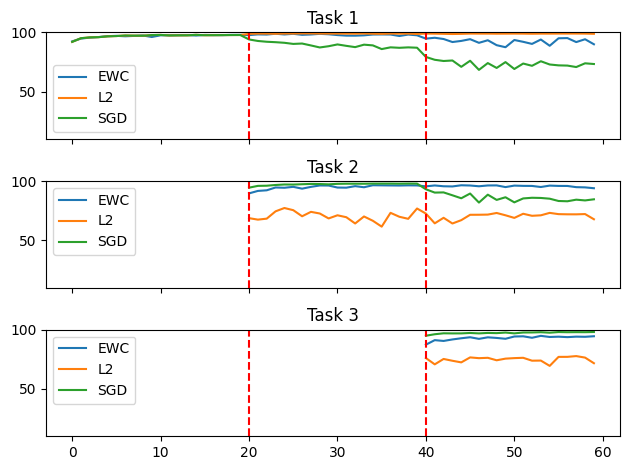

In [31]:
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(
    accuracy_EWC_validation_1[0]
    + accuracy_EWC_validation_2[0]
    + accuracy_EWC_validation_3[0],
    label="EWC",
)
ax[0].plot(
    accuracy_L2_validation_1[0]
    + accuracy_L2_validation_2[0]
    + accuracy_L2_validation_3[0],
    label="L2",
)
ax[0].plot(
    accuracy_SGD_validation_1[0]
    + accuracy_SGD_validation_2[0]
    + accuracy_SGD_validation_3[0],
    label="SGD",
)

ax[1].plot(
    range(20, 60),
    accuracy_EWC_validation_2[1] + accuracy_EWC_validation_3[1],
    label="EWC",
)
ax[1].plot(
    range(20, 60), accuracy_L2_validation_2[1] + accuracy_L2_validation_3[1], label="L2"
)
ax[1].plot(
    range(20, 60),
    accuracy_SGD_validation_2[1] + accuracy_SGD_validation_3[1],
    label="SGD",
)

ax[2].plot(range(40, 60), accuracy_EWC_validation_3[2], label="EWC")
ax[2].plot(range(40, 60), accuracy_L2_validation_3[2], label="L2")
ax[2].plot(range(40, 60), accuracy_SGD_validation_3[2], label="SGD")

for i in range(0, 3):
    ax[i].legend()
    ax[i].set_ylim([10, 100])
    ax[i].set_title(f"Task {i+1}")
    ax[i].axvline(x=20, ls="--", color="red")  # Add vertical line at x=20
    ax[i].axvline(x=40, ls="--", color="red")  # Add vertical line at x=40

plt.tight_layout()
plt.show()

## Second Part ##

In [36]:
tasks = [
    data_generation(i, num_workers=0) for i in range(10)
]  # Tasks[1,2,3] is test, train, validation